In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import tensorflow as tf
from tensorflow import keras
from toai.imports import *

from data import DataContainer
from image import *
from image_learner import ImageLearner
from transformations import ImageParser, ImageCropTransformation, ImageRandomCropTransformation, ImageLRFlpTransformation

import sklearn
import metrics

In [5]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [6]:
DATA_DIR = Path('data')
TEMP_DIR = Path('temp')
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [7]:
df = pd.read_csv('train.csv', low_memory=False)

In [8]:
df.head().T

,0,1,2,3,4
category_id,19,19,0,0,0
date_captured,2011-05-13 23:43:18,2012-03-17 03:48:44,2014-05-11 11:56:46,2013-10-06 02:00:00,2011-07-12 13:11:16
file_name,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,588a679f-23d2-11e8-a6a3-ec086b02610b.jpg,59279ce3-23d2-11e8-a6a3-ec086b02610b.jpg,5a2af4ab-23d2-11e8-a6a3-ec086b02610b.jpg,599fbd89-23d2-11e8-a6a3-ec086b02610b.jpg
frame_num,1,2,1,1,3
id,5998cfa4-23d2-11e8-a6a3-ec086b02610b,588a679f-23d2-11e8-a6a3-ec086b02610b,59279ce3-23d2-11e8-a6a3-ec086b02610b,5a2af4ab-23d2-11e8-a6a3-ec086b02610b,599fbd89-23d2-11e8-a6a3-ec086b02610b
location,33,115,96,57,46
rights_holder,Justin Brown,Justin Brown,Erin Boydston,Erin Boydston,Justin Brown
seq_id,6f084ccc-5567-11e8-bc84-dca9047ef277,6f12067d-5567-11e8-b3c0-dca9047ef277,6faa92d1-5567-11e8-b1ae-dca9047ef277,6f7d4702-5567-11e8-9e03-dca9047ef277,6f1728a1-5567-11e8-9be7-dca9047ef277
seq_num_frames,3,3,1,1,3
width,1024,1024,1024,1024,1024


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196299 entries, 0 to 196298
Data columns (total 11 columns):
category_id       196299 non-null int64
date_captured     196299 non-null object
file_name         196299 non-null object
frame_num         196299 non-null int64
id                196299 non-null object
location          196299 non-null int64
rights_holder     196299 non-null object
seq_id            196299 non-null object
seq_num_frames    196299 non-null int64
width             196299 non-null int64
height            196299 non-null int64
dtypes: int64(6), object(5)
memory usage: 16.5+ MB


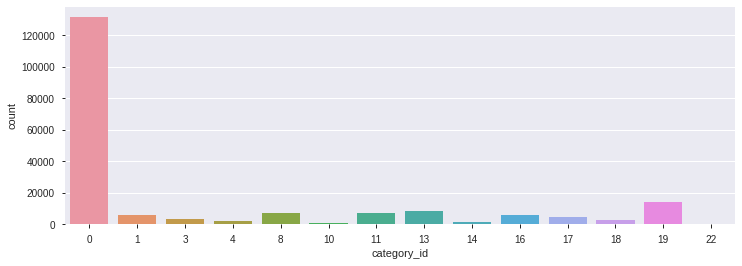

In [10]:
plt.figure(figsize=(12,4))
sns.countplot(x='category_id', data=df);

In [11]:
df['category_id'].value_counts()

0     131457
19     14106
13      8623
11      7209
8       6938
1       6102
16      5975
17      4759
3       3398
18      3035
4       2210
14      1361
10      1093
22        33
Name: category_id, dtype: int64

In [12]:
df['path'] = df['file_name'].apply(lambda fn : str(DATA_DIR/'train'/fn))

In [13]:
df.head(1)

,category_id,date_captured,file_name,frame_num,id,location,rights_holder,seq_id,seq_num_frames,width,height,path
0,19,2011-05-13 23:43:18,5998cfa4-23d2-11e8-a6a3-ec086b02610b.jpg,1,5998cfa4-23d2-11e8-a6a3-ec086b02610b,33,Justin Brown,6f084ccc-5567-11e8-bc84-dca9047ef277,3,1024,747,data/train/5998cfa4-23d2-11e8-a6a3-ec086b02610...


In [14]:
def create_class_weight_map(df: pd.DataFrame, class_name: str):
    classes = np.unique(df[class_name])
    weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes, df[class_name])
    
    return { key: value for key, value in zip(classes, weights) }

In [15]:
train_data, validation_data = train_test_split(df, test_size=0.4, stratify=df['category_id'])

In [16]:
validation_data, test_data = train_test_split(validation_data, test_size=0.5, stratify=validation_data['category_id'])

In [17]:
[data.shape for data in (train_data, validation_data, test_data)]

[(117779, 12), (39260, 12), (39260, 12)]

In [18]:
IMG_DIMS = (100, 100, 3)

In [19]:
class_weights = create_class_weight_map(train_data, 'category_id'); class_weights

{0: 0.10666107607431745,
 1: 2.2979474772700668,
 3: 4.125937084004764,
 4: 6.344483947425124,
 8: 2.0208469167152807,
 10: 12.824368466898955,
 11: 1.9451527663088357,
 13: 1.6259732729581975,
 14: 10.29716733694702,
 16: 2.3466626818091254,
 17: 2.9466850137603204,
 18: 4.619871342276614,
 19: 0.9940666092739825,
 22: 420.63928571428573}

In [20]:
base_config = ImageDatasetConfig(
    img_dims=IMG_DIMS,
    batch_size=32,
    preprocess_pipeline=[
        ImageParser(),
        ImageCropTransformation(IMG_DIMS)
    ],
)

data_container = DataContainer(
    train=ImageDataset(base_config.copy(
        preprocess_pipeline=[
            ImageLRFlpTransformation()
        ],
        shuffle=True,
    )).build_from_df(train_data, 'path', 'category_id'),
    validation=ImageDataset(base_config.copy(
        preprocess_pipeline = [
            ImageLRFlpTransformation(),
        ],
    )).build_from_df(validation_data, 'path', 'category_id'),
    test=ImageDataset(base_config.copy(
        preprocess_pipeline=[
#             ImageCropTransformation(IMG_DIMS)
        ],
    )).build_from_df(test_data, 'path', 'category_id'),
)

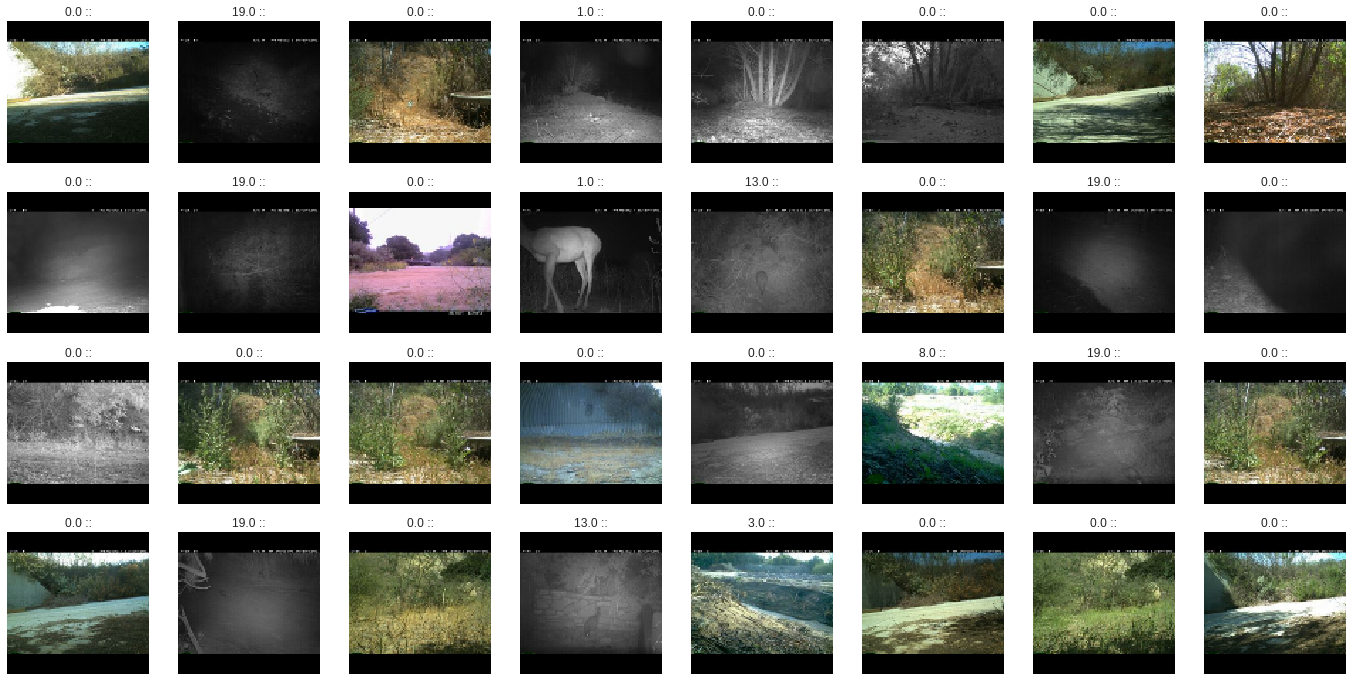

In [21]:
data_container.train.show()

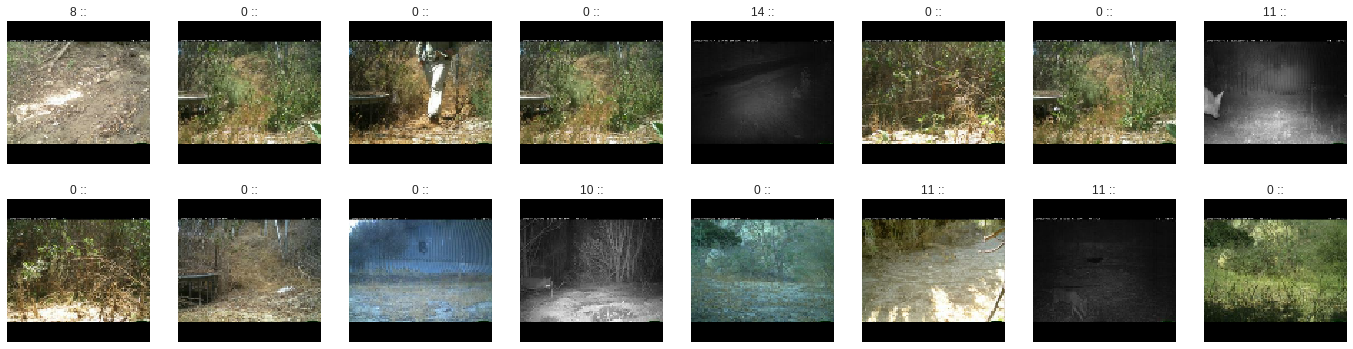

In [84]:
data_container.test.show()

In [22]:
learner = ImageLearner(
    model_path=Path('xception'),
    data=data_container,
    base_model=keras.applications.Xception,
    input_shape=IMG_DIMS,
    activation=keras.activations.softmax,
    dropout=0.1,
)

In [23]:
learner.auto_train(
    easing_epochs=1,
    epochs=1,
    optimizer=keras.optimizers.RMSprop,
    lr=1e-5,
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[keras.metrics.sparse_categorical_accuracy],
)

Freezing all except last model layers
Training frozen model
Train for 3681 steps, validate for 1227 steps
 462/3681 [==>...........................] - ETA: 1:44 - loss: nan - sparse_categorical_accuracy: 0.6688WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 